#### Software defects prediction

In [1]:
##importing the basic libraraies
import pandas as pd
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, LabelEncoder

In [3]:
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [4]:
##loading the traing set into pandas dataframe
data = pd.read_csv(r'C:\Users\prasa\Desktop\softwaredefects\data\train.csv',index_col='id')
test_data = pd.read_csv(r'C:\Users\prasa\Desktop\softwaredefects\data\test.csv',index_col='id')

In [5]:
##shape of the dataframe 
data.shape

(101763, 22)

In [6]:
##Check the data loaded
data.head(10)

loc  v(g)  ev(g)  iv(g)      n       v     l      d      i        e  ...  \
id                                                                        ...   
0   22.0   3.0    1.0    2.0   60.0  278.63  0.06  19.56  14.25  5448.79  ...   
1   14.0   2.0    1.0    2.0   32.0  151.27  0.14   7.00  21.11   936.71  ...   
2   11.0   2.0    1.0    2.0   45.0  197.65  0.11   8.05  22.76  1754.01  ...   
3    8.0   1.0    1.0    1.0   23.0   94.01  0.19   5.25  17.86   473.66  ...   
4   11.0   2.0    1.0    2.0   17.0   60.94  0.18   5.63  12.44   365.67  ...   
5   23.0   4.0    4.0    3.0   69.0  338.21  0.07  14.15  22.81  3772.51  ...   
6   24.0   4.0    1.0    4.0   60.0  294.41  0.08  12.46  24.62  3295.25  ...   
7   14.0   1.0    1.0    1.0   49.0  221.65  0.18   5.47  46.06  1183.48  ...   
8   34.0  10.0    1.0    4.0  122.0  684.98  0.07  14.33  43.43  9941.84  ...   
9    9.0   2.0    1.0    2.0   16.0   55.35  0.11   9.00   6.15   498.16  ...   

    lOCode  lOComment  lOBlank  locCodeAndComment  uniq_Op  uniq_Opnd  \
id                                                                      
0       17          1        1                  0     16.0        9.0   
1       11          0        1                  0     11.0       11.0   
2        8          0        1                  0     12.0       11.0   
3        4          0        2                  0      8.0        6.0   
4        7          0        2                  0      7.0        6.0   
5       17          1        2                  0     16.0       10.0   
6       19          0        3                  0     14.0       13.0   
7       11          0        2                  0      7.0       18.0   
8       29          1        3                  0     16.0       29.0   
9        4          0        2                  0      9.0        2.0   

    total_Op  total_Opnd  branchCount  defects  
id                                              
0       38.0        22.0          5.0    False  
1       18.0        14.0          3.0    False  
2       28.0        17.0          3.0    False  
3       16.0         7.0          1.0     True  
4       10.0        10.0          3.0    False  
5       40.0        19.0          7.0    False  
6       40.0        23.0          7.0    False  
7       26.0        23.0          1.0    False  
8       75.0        47.0         19.0    False  
9       12.0         4.0          3.0    False  

[10 rows x 22 columns]

In [7]:
##Basic statistical analysis of each column in the dataframe
data.describe()

loc           v(g)          ev(g)          iv(g)  \
count  101763.000000  101763.000000  101763.000000  101763.000000   
mean       37.347160       5.492684       2.845022       3.498826   
std        54.600401       7.900855       4.631262       5.534541   
min         1.000000       1.000000       1.000000       1.000000   
25%        13.000000       2.000000       1.000000       1.000000   
50%        22.000000       3.000000       1.000000       2.000000   
75%        42.000000       6.000000       3.000000       4.000000   
max      3442.000000     404.000000     165.000000     402.000000   

                   n              v              l              d  \
count  101763.000000  101763.000000  101763.000000  101763.000000   
mean       96.655995     538.280956       0.111634      13.681881   
std       171.147191    1270.791601       0.100096      14.121306   
min         0.000000       0.000000       0.000000       0.000000   
25%        25.000000      97.670000       0.050000       5.600000   
50%        51.000000     232.790000       0.090000       9.820000   
75%       111.000000     560.250000       0.150000      18.000000   
max      8441.000000   80843.080000       1.000000     418.200000   

                   i             e  ...              t         lOCode  \
count  101763.000000  1.017630e+05  ...  101763.000000  101763.000000   
mean       27.573007  2.085359e+04  ...    1141.357982      22.802453   
std        22.856742  1.905714e+05  ...    9862.795472      38.541010   
min         0.000000  0.000000e+00  ...       0.000000       0.000000   
25%        15.560000  5.647300e+02  ...      31.380000       7.000000   
50%        23.360000  2.256230e+03  ...     125.400000      14.000000   
75%        34.340000  1.019324e+04  ...     565.920000      26.000000   
max       569.780000  1.684662e+07  ...  935923.390000    2824.000000   

           lOComment        lOBlank  locCodeAndComment        uniq_Op  \
count  101763.000000  101763.000000      101763.000000  101763.000000   
mean        1.773945       3.979865           0.196604      11.896131   
std         5.902412       6.382358           0.998906       6.749549   
min         0.000000       0.000000           0.000000       0.000000   
25%         0.000000       1.000000           0.000000       8.000000   
50%         0.000000       2.000000           0.000000      11.000000   
75%         1.000000       5.000000           0.000000      16.000000   
max       344.000000     219.000000          43.000000     410.000000   

           uniq_Opnd       total_Op     total_Opnd    branchCount  
count  101763.000000  101763.000000  101763.000000  101763.000000  
mean       15.596671      57.628116      39.249698       9.839549  
std        18.064261     104.537660      71.692309      14.412769  
min         0.000000       0.000000       0.000000       1.000000  
25%         7.000000      15.000000      10.000000       3.000000  
50%        12.000000      30.000000      20.000000       5.000000  
75%        20.000000      66.000000      45.000000      11.000000  
max      1026.000000    5420.000000    3021.000000     503.000000  

[8 rows x 21 columns]

In [8]:
# Checking if there are any missing values
data.isna().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

In [9]:
##Checking if there are any duplicated values
data.duplicated().sum()

0

In [10]:
##checking the percentage of defects in the data
data.defects.mean()

0.22664426166681406

#### Unbalanced data :
#### The data consists of 101763 observations.This dataset is unbalanced with only 23% of defects

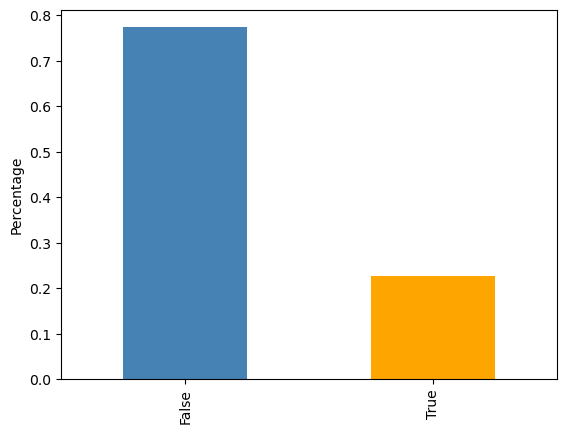

In [11]:
data['defects'].value_counts(normalize = True).plot(kind = 'bar', color = ['steelblue', 'orange'])
plt.ylabel('Percentage');

#### Numerical Distribution of features with repect to defects

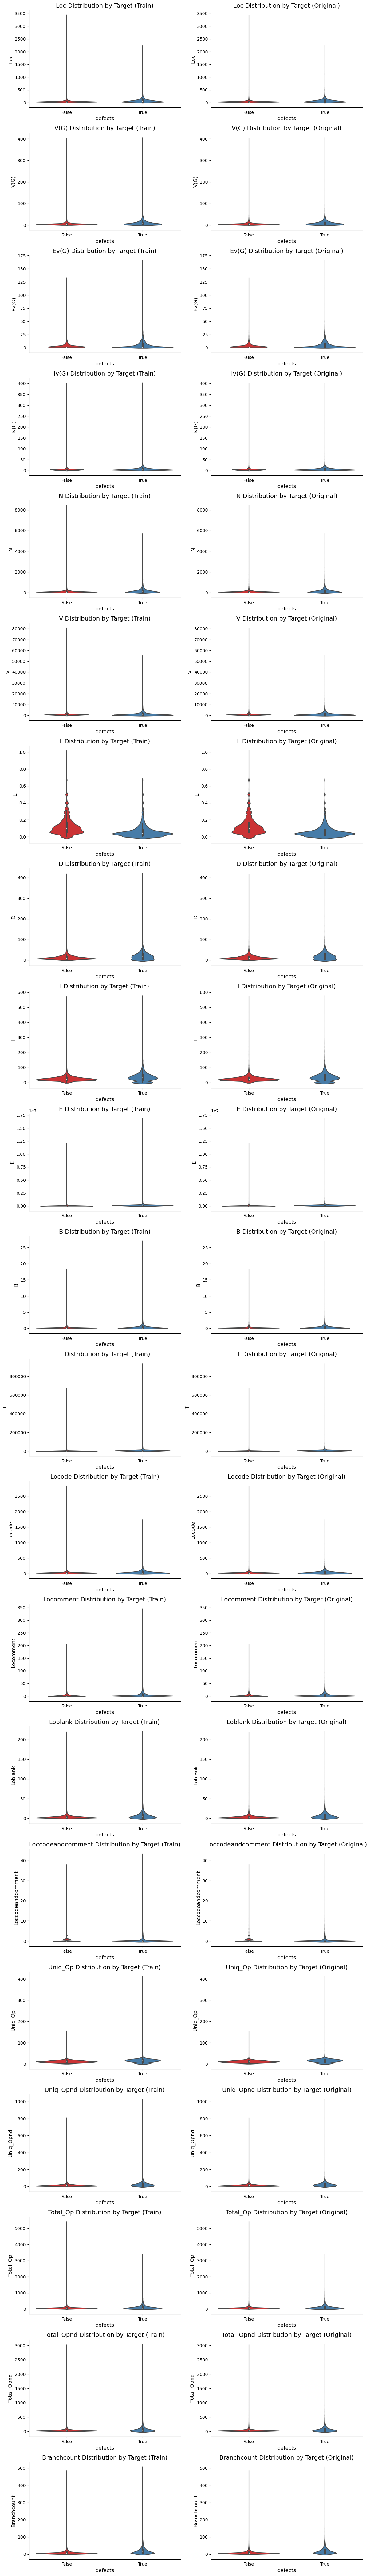

In [12]:
cont_cols = [f for f in data.columns if data[f].dtype != 'O' and data[f].nunique() > 2]
n_rows = len(cont_cols)
fig, axs = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
sns.set_palette("Set1")
for i, col in enumerate(cont_cols):
    sns.violinplot(x='defects', y=col, data=data, ax=axs[i, 0])
    axs[i, 0].set_title(f'{col.title()} Distribution by Target (Train)', fontsize=14)
    axs[i, 0].set_xlabel('defects', fontsize=12)
    axs[i, 0].set_ylabel(col.title(), fontsize=12)
    sns.despine()

    sns.violinplot(x='defects', y=col, data=data, ax=axs[i, 1])
    axs[i, 1].set_title(f'{col.title()} Distribution by Target (Original)', fontsize=14)
    axs[i, 1].set_xlabel('defects', fontsize=12)
    axs[i, 1].set_ylabel(col.title(), fontsize=12)
    sns.despine()

fig.tight_layout()

plt.show()

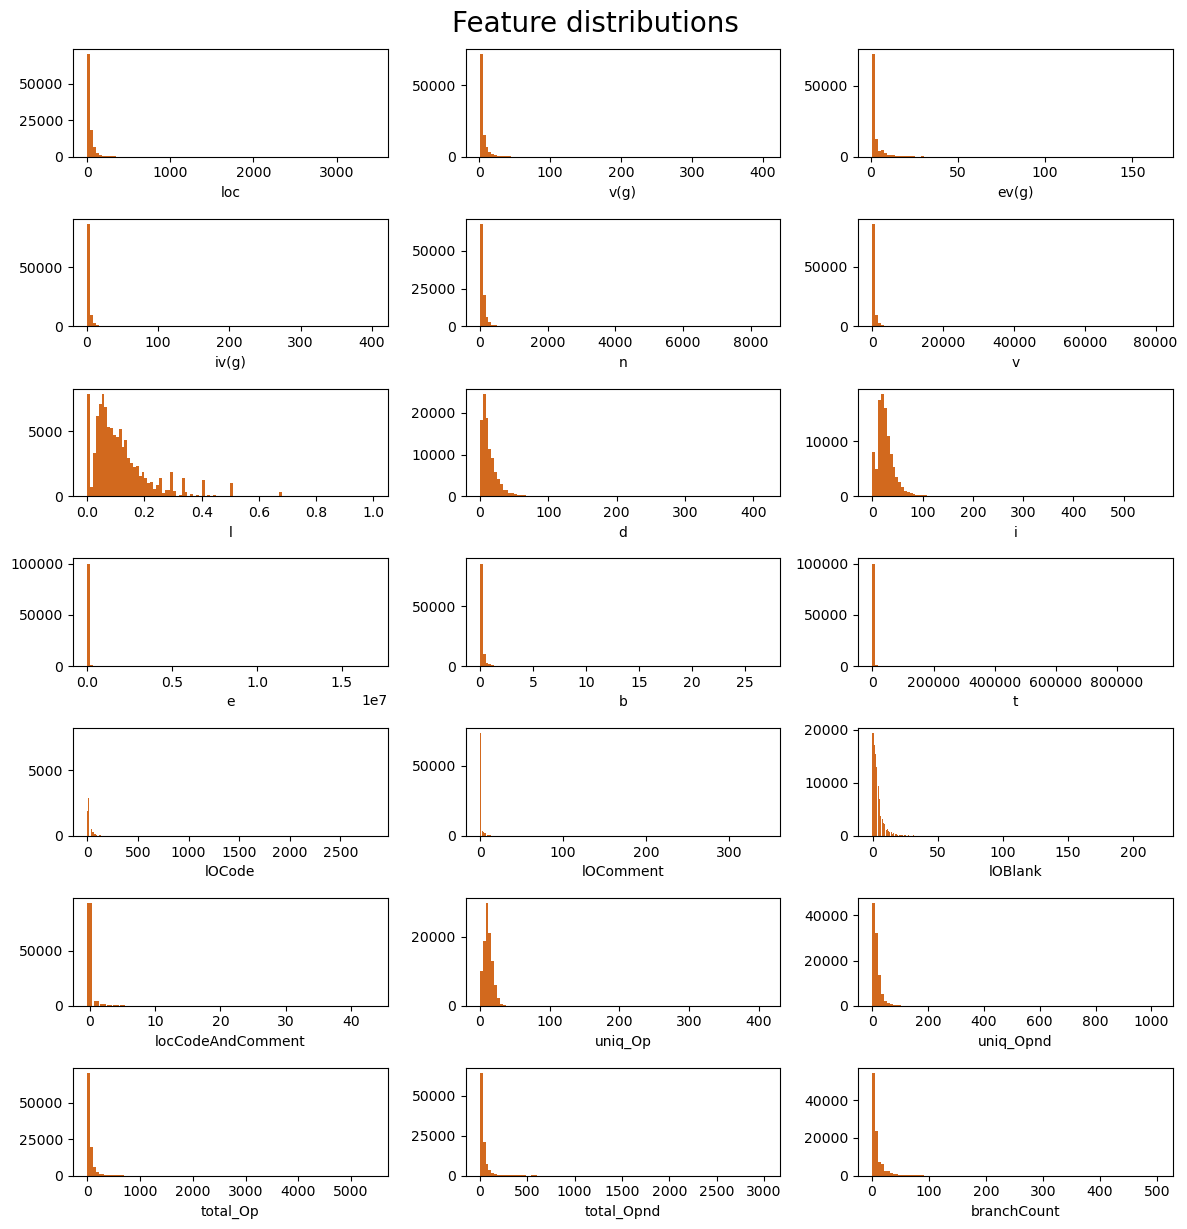

In [13]:
## Plotting the distribution  of each column

_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test_data.columns, axs.ravel()):
    if data[col].dtype == float:
        ax.hist(data[col], bins=100, color='chocolate')
    else: #int
        vc = data[col].value_counts()
        ax.bar(vc.index, vc, color='chocolate')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

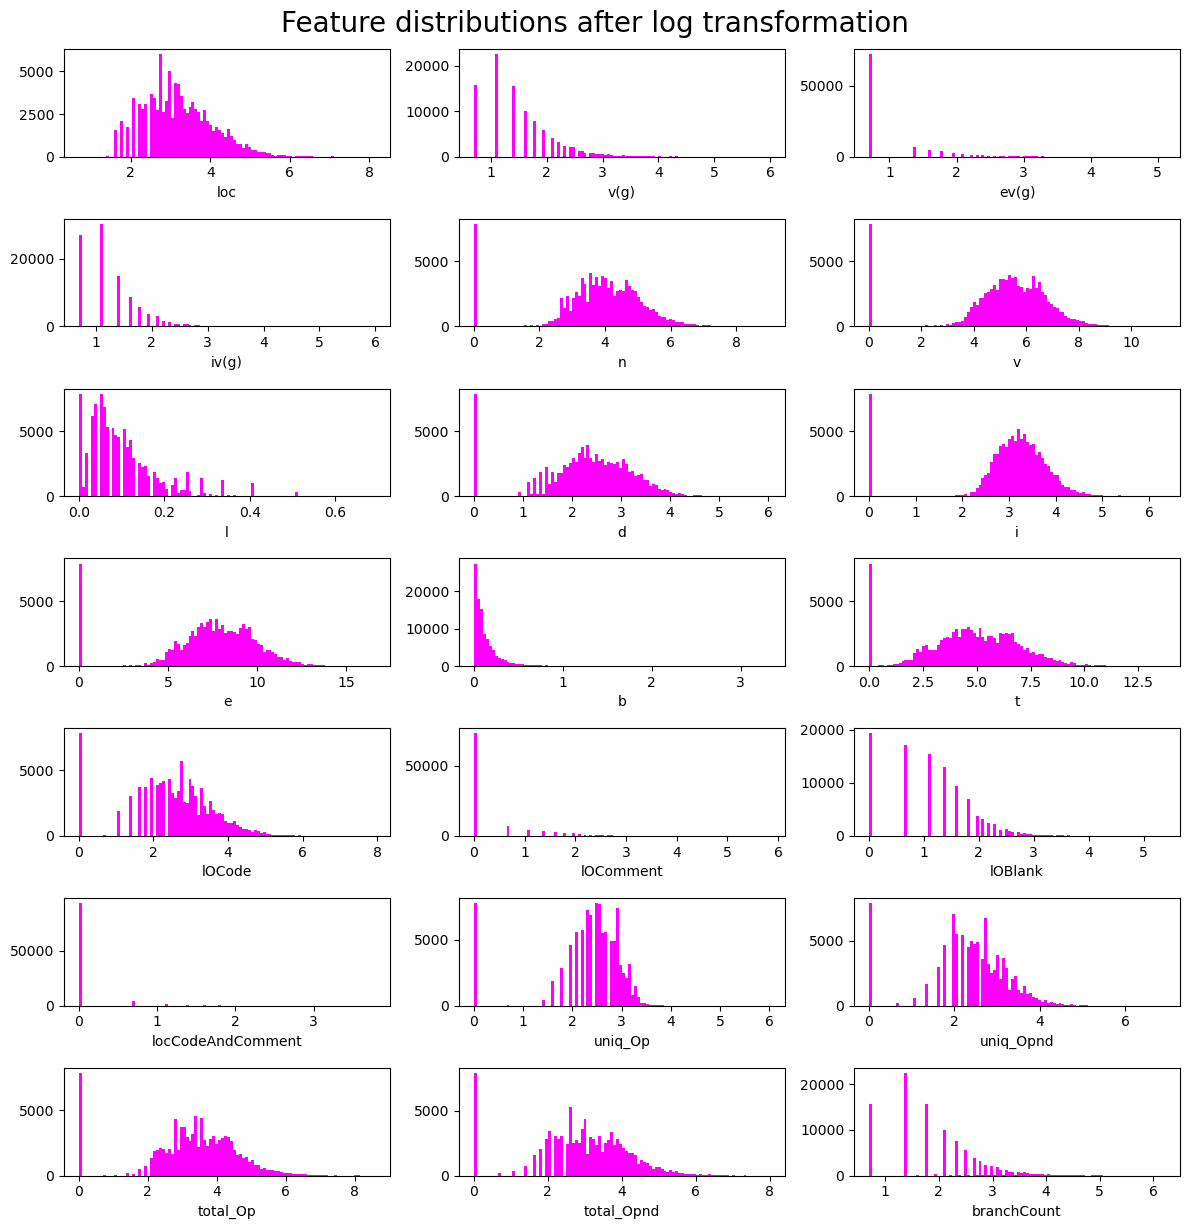

In [14]:
## ALmost all the features are skewed to the left
## Applyting log transformation to correct the skewness
_, axs = plt.subplots(7, 3, figsize=(12, 12))
for col, ax in zip(test_data.columns, axs.ravel()):
    ax.hist(np.log1p(data[col]), bins=100, color='magenta')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Feature distributions after log transformation', y=1.02, fontsize=20)
plt.show()

## Correlation matrix 
### To check the potential correlation among the features

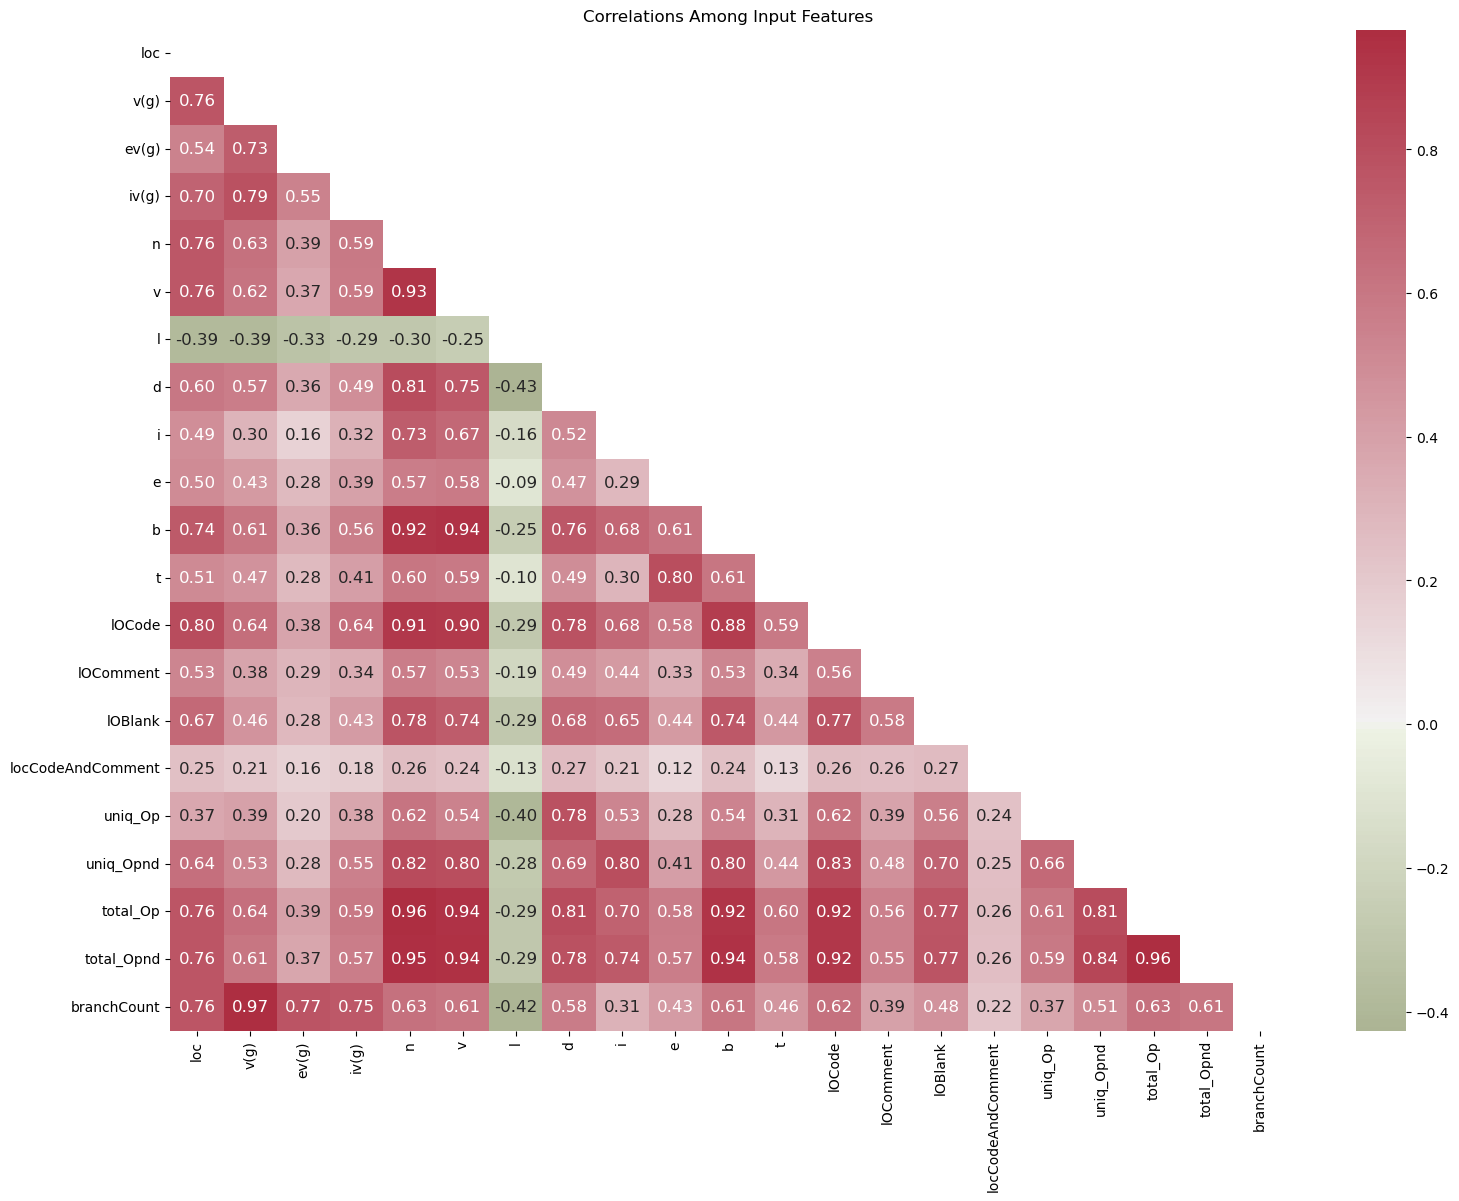

In [15]:
# Dropping the index and target columns
corr_mat = data.drop(columns = [ 'defects'], axis = 1).corr()

data_mask = np.triu(np.ones_like(corr_mat, dtype = bool))
cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)
f, ax = plt.subplots(figsize = (18, 13))
sns.heatmap(corr_mat, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('Correlations Among Input Features');

#### Couple of observations from the correlation matrix:
  ##### l is the only feature that is negative correlated with the other features.
  ##### There is a 97% correlation between branchCount and v(g).
  ##### There is a 96% correlation between total_Opnd and total_Op
  ##### There is a 96% correlation between total_Op and n


#### Based on the above correlation heatmap, we proceed to explore the idea of dimension reduction via PCA. Notice the the all the input features are right-skewed, so before running PCA , log-transform the features 

In [16]:
data.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')

In [17]:
colnames = data.drop(columns = ['defects'], axis = 1).columns.tolist()

pca_md = Pipeline([('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
                   ('stand', StandardScaler()), 
                   ('pca', PCA())]).fit(data[colnames])

pca_md

Pipeline(steps=[('log-tran',
                 ColumnTransformer(transformers=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['loc', 'v(g)', 'ev(g)',
                                                   'iv(g)', 'n', 'v', 'l', 'd',
                                                   'i', 'e', 'b', 't', 'lOCode',
                                                   'lOComment', 'lOBlank',
                                                   'locCodeAndComment',
                                                   'uniq_Op', 'uniq_Opnd',
                                                   'total_Op', 'total_Opnd',
                                                   'branchCount'])])),
                ('stand', StandardScaler()), ('pca', PCA())])

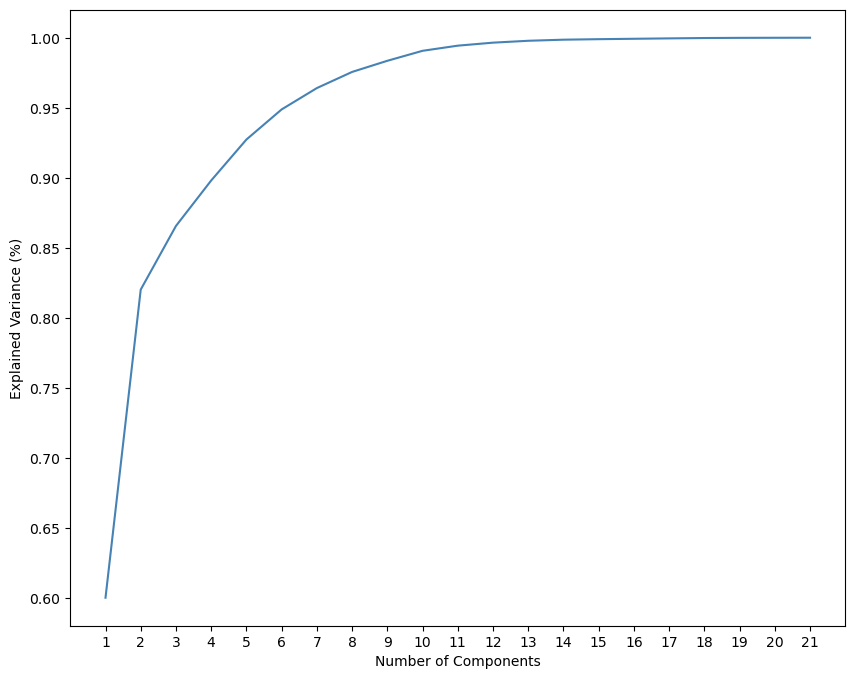

In [18]:
plt.figure(figsize = (10, 8))
ax = sns.lineplot(x = [i for i in range(1, 22)], y = np.cumsum(pca_md['pca'].explained_variance_ratio_), color = 'steelblue', markers = True);
ax.set_xlabel('Number of Components')
ax.set_ylabel('Explained Variance (%)')
ax.set_xticks([i for i in range(1, 22)]);

From the above, we see that the first 10 components explain more than 99% of the variability in the data. Next let's visualize the the components to see if there is a pattern to be exploit.

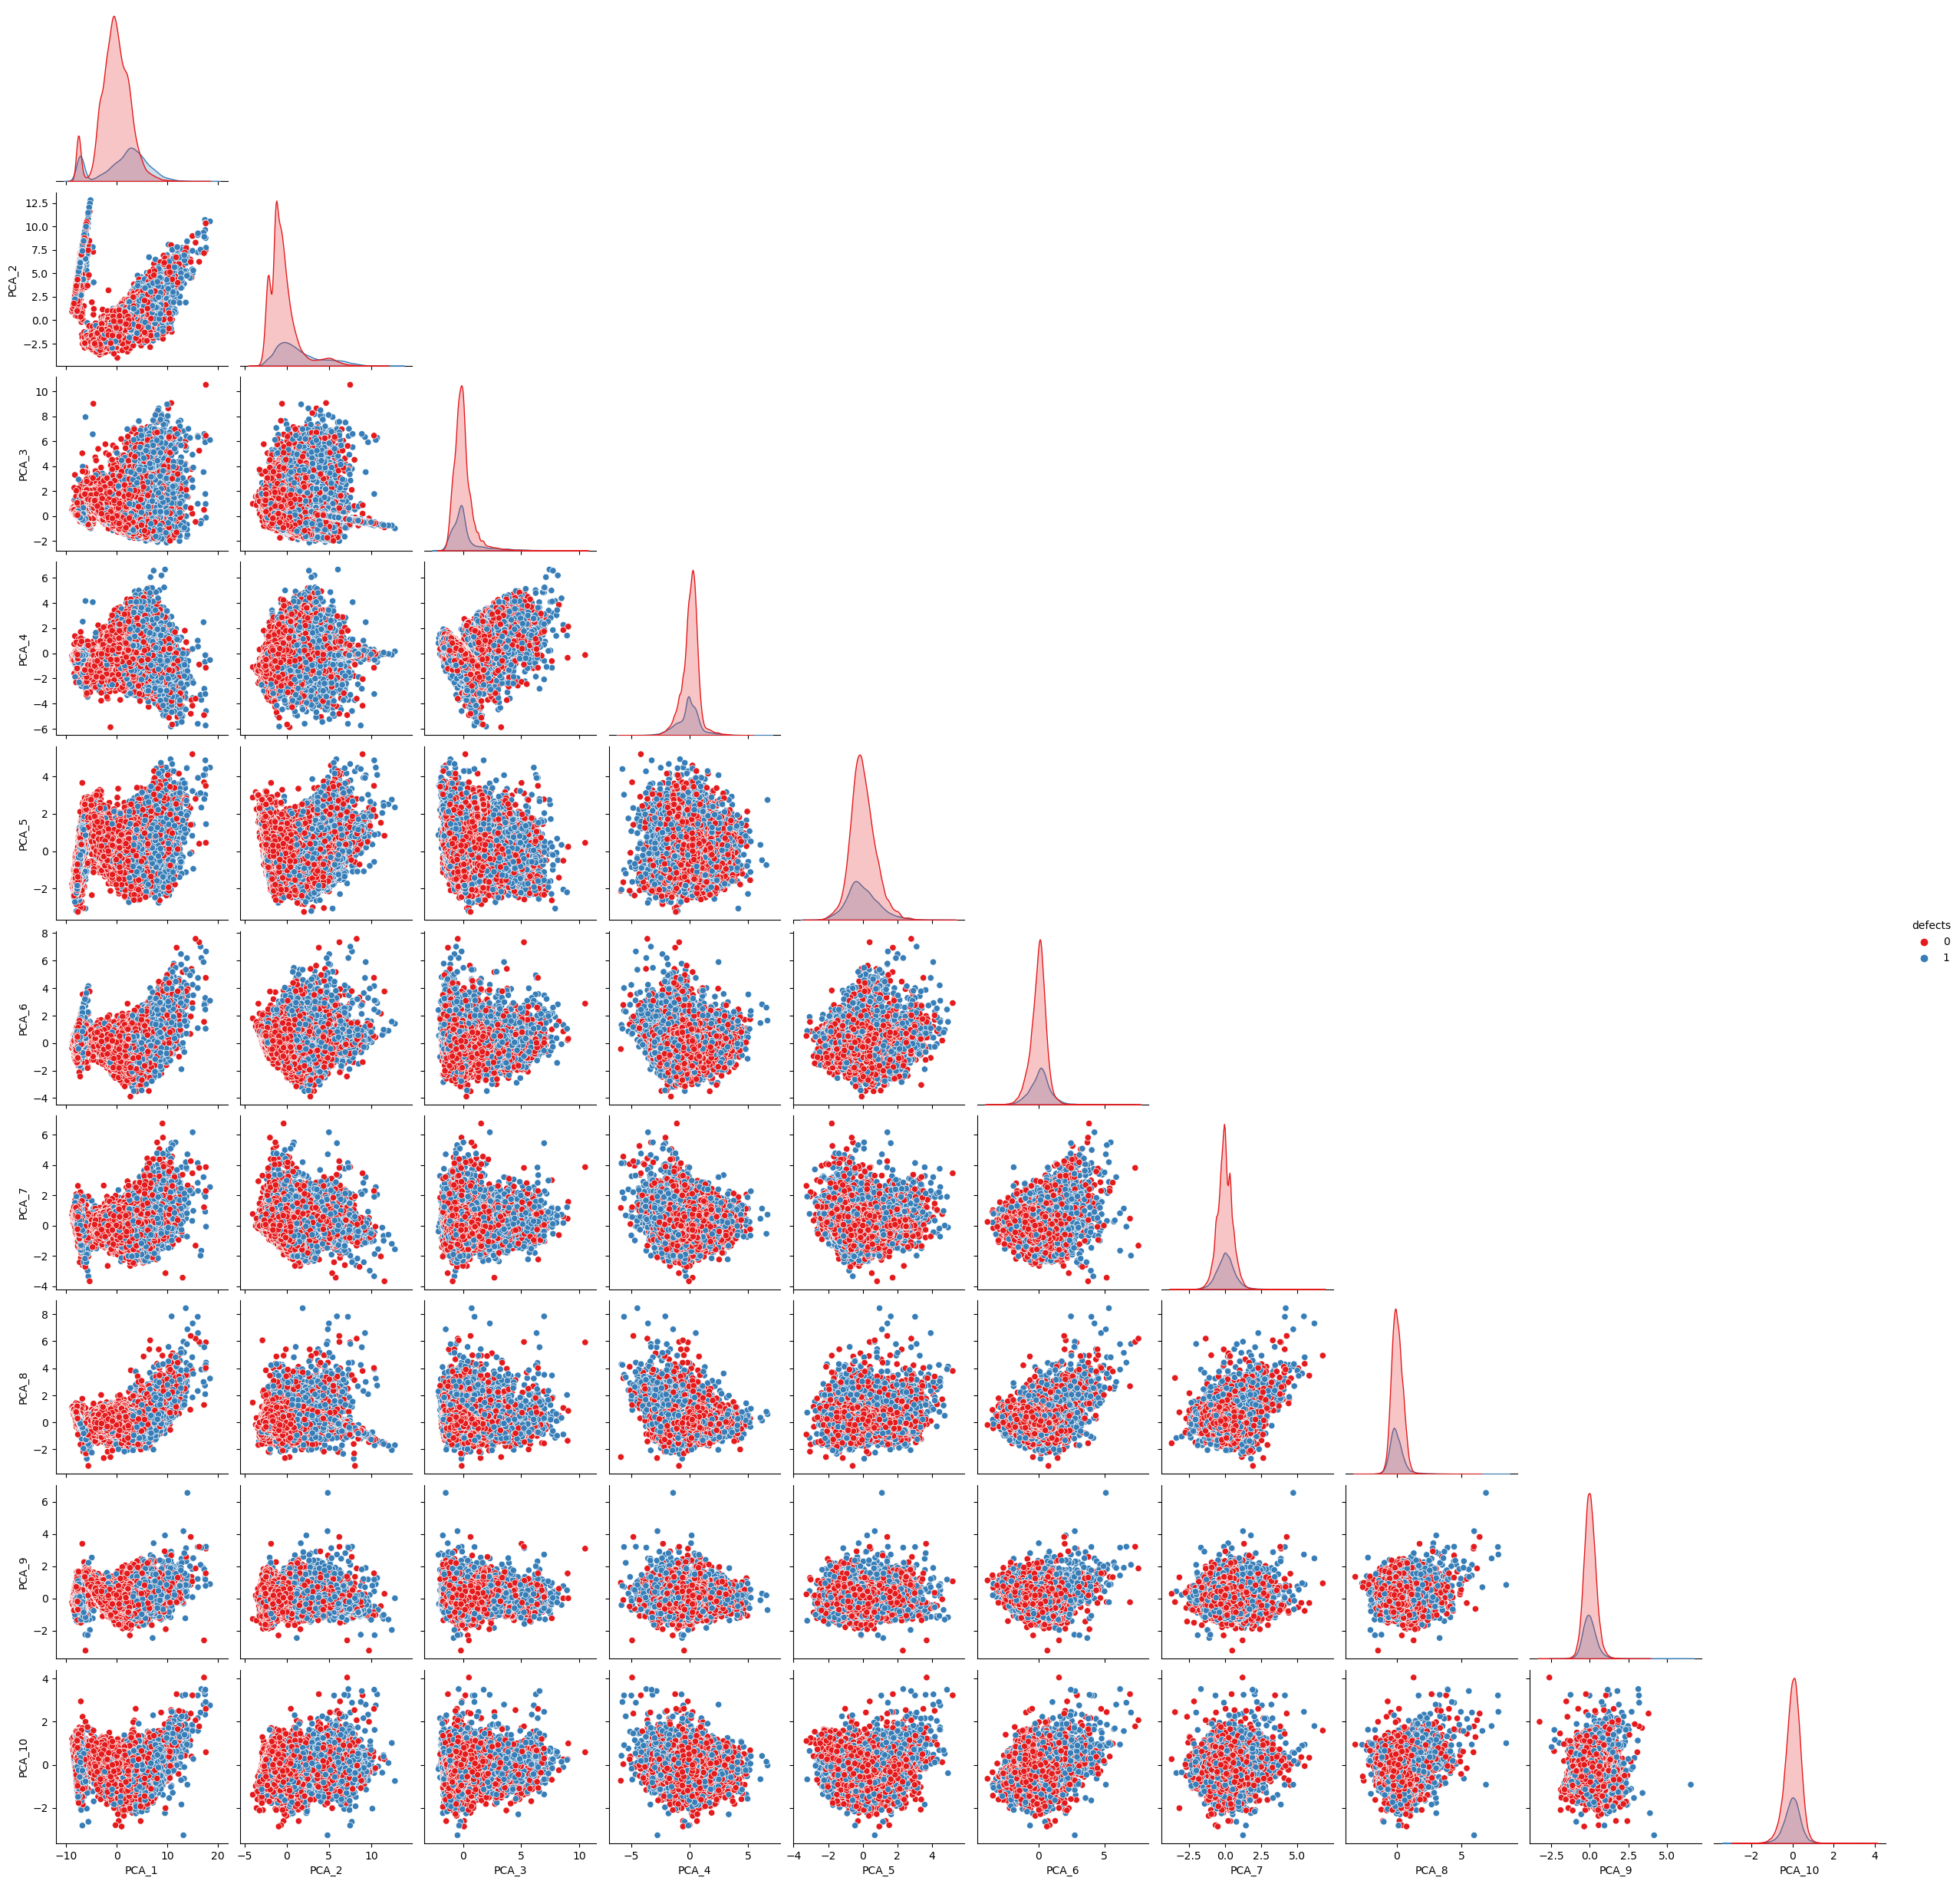

In [19]:

pca_10 = Pipeline([('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
                   ('stand', StandardScaler()), 
                   ('pca', PCA(n_components = 10))]).fit_transform(data[colnames])

pca_10 = pd.DataFrame(pca_10, columns = [str('PCA_') + str(i) for i in range(1, 11)])
pca_10['defects'] = data['defects'].map({False: 0, True: 1})

sns.pairplot(data = pca_10, hue = 'defects', corner = True);

From the above PCA pair-plots, these are some observations:

        The two classes are not linearly separable.
        There are some samples (defects = True) that are difficult to predict. 
        For instance, if we take a close look at PCA_1 and PCA_2 plot, in the bottom left corner, there are some blue samples (defects = True) when the majority of samples in that area are red (defects = False).

In [20]:
from tqdm import tqdm

100%|██████████| 19/19 [01:20<00:00,  4.24s/it]


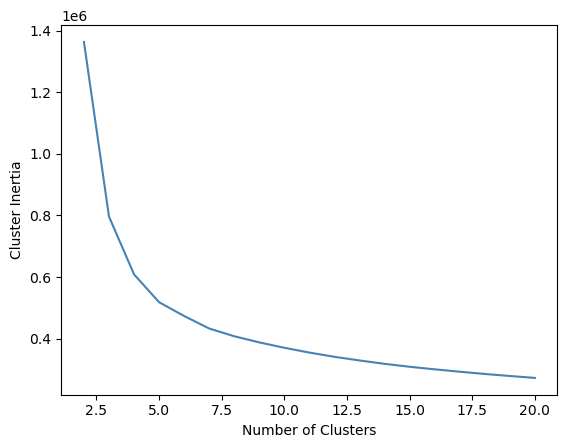

In [21]:
### k-means to see if there is an interesting patterns

inertias = list()

for i in tqdm(range(2, 21)):

    kmeans_md = Pipeline([('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
                          ('stand', StandardScaler()), 
                          ('kmeans', KMeans(n_clusters = i, n_init = 20, random_state = 42))]).fit(data[colnames])

    inertias.append(kmeans_md['kmeans'].inertia_)
    
sns.lineplot(x = [i for i in range(2, 21)], y = inertias, color = 'steelblue')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Inertia');

From the above, plot, based on the cluster intertia, it seems that 5 clusters is the appropriate number of clusters for this dataset (based on the elbow approach).

In [22]:
###exploring the defects in each cluster
kmeans = Pipeline([('log-tran', ColumnTransformer([('log', FunctionTransformer(np.log1p), colnames)])), 
                   ('stand', StandardScaler()), 
                   ('kmeans', KMeans(n_clusters = 5, n_init = 20, random_state = 42))]).fit(data[colnames])

data['cluster'] = kmeans['kmeans'].labels_

print('The proportion of defects in each of the clusters is \n')
print(data.groupby('cluster')['defects'].mean())

The proportion of defects in each of the clusters is 

cluster
0    0.109429
1    0.471916
2    0.641147
3    0.077083
4    0.301682
Name: defects, dtype: float64


From the above, these are a couple of observations:

Cluster 4 is the cluster with higher number of defects.
Cluster 2 is the second cluster with the highest number of defects.
Cluster 0 is the cluster with the least number of defects.

In [23]:
##Bivariate relationship

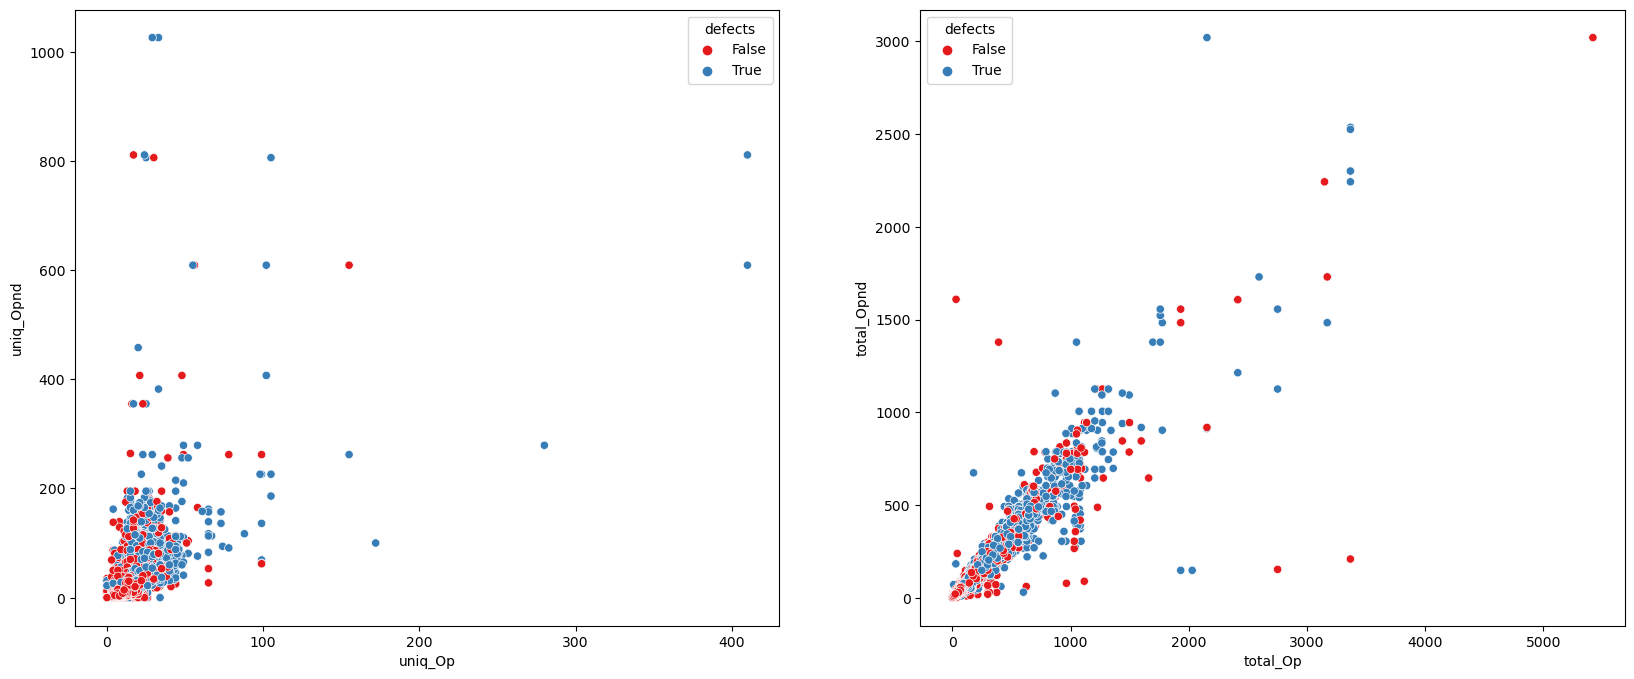

In [24]:
fig, axes = plt.subplots(1, 2, figsize = (20,8))

sns.scatterplot(ax = axes[0], data = data, x = 'uniq_Op', y = 'uniq_Opnd', hue = 'defects');
sns.scatterplot(ax = axes[1], data = data, x = 'total_Op', y = 'total_Opnd', hue = 'defects');

From the above plots, these are a couple of observations:

There are several outliers in this data.
There is not a clear pattern that can be leveraged to separate the two classes

In [25]:
train  =data

In [27]:
train.head(5)

loc  v(g)  ev(g)  iv(g)     n       v     l      d      i        e  ...  \
id                                                                       ...   
0   22.0   3.0    1.0    2.0  60.0  278.63  0.06  19.56  14.25  5448.79  ...   
1   14.0   2.0    1.0    2.0  32.0  151.27  0.14   7.00  21.11   936.71  ...   
2   11.0   2.0    1.0    2.0  45.0  197.65  0.11   8.05  22.76  1754.01  ...   
3    8.0   1.0    1.0    1.0  23.0   94.01  0.19   5.25  17.86   473.66  ...   
4   11.0   2.0    1.0    2.0  17.0   60.94  0.18   5.63  12.44   365.67  ...   

    lOComment  lOBlank  locCodeAndComment  uniq_Op  uniq_Opnd  total_Op  \
id                                                                        
0           1        1                  0     16.0        9.0      38.0   
1           0        1                  0     11.0       11.0      18.0   
2           0        1                  0     12.0       11.0      28.0   
3           0        2                  0      8.0        6.0      16.0   
4           0        2                  0      7.0        6.0      10.0   

    total_Opnd  branchCount  defects  cluster  
id                                             
0         22.0          5.0    False        0  
1         14.0          3.0    False        0  
2         17.0          3.0    False        0  
3          7.0          1.0     True        3  
4         10.0          3.0    False        3  

[5 rows x 23 columns]

## BASE MODEL

In [28]:
test_data.columns

Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount'],
      dtype='object')

In [29]:
X = train.drop(columns =  ['defects', 'cluster'], axis = 1)
Y = train['defects'].map({False: 0, True: 1})

test_cv = test_data

In [30]:
def hill_climbing(x, y, x_test):
    
    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = roc_auc_score(y, x[col])

    # Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = True)}

    # Sort oof_df and test_preds
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    current_best_test_preds = x_test.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.51, 0.01) 
    history = [roc_auc_score(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = roc_auc_score(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = roc_auc_score(y, potential_ensemble)
                if cv_score > potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True
        
    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds
    
    return [hill_ens_pred_1, hill_ens_pred_2]


In [31]:
ens_cv_scores, ens_preds = list(), list()
hill_ens_cv_scores, hill_ens_preds =  list(), list()

sk = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    print('----------------------------------------------------------')
    
    ########
    ## RF ##
    ########

    RF_md = RandomForestClassifier(n_estimators = 500, 
                                   max_depth = 7,
                                   min_samples_split = 15,
                                   min_samples_leaf = 10).fit(X_train, Y_train)
    
    RF_pred = RF_md.predict_proba(X_test)[:, 1]
    RF_score = roc_auc_score(Y_test, RF_pred)

    print('Fold', i, '==> RF oof ROC-AUC score is ==>', RF_score)

    RF_pred_test = RF_md.predict_proba(test_cv)[:, 1]
    
    #################
    ## Extra Trees ##
    #################

    ET_md = ExtraTreesClassifier(n_estimators = 500, 
                                 max_depth = 7,
                                 min_samples_split = 15,
                                 min_samples_leaf = 10).fit(X_train, Y_train)

    ET_pred = ET_md.predict_proba(X_test)[:, 1]
    ET_score = roc_auc_score(Y_test, ET_pred)

    print('Fold', i, '==> ET oof ROC-AUC score is ==>', ET_score)

    ET_pred_test = ET_md.predict_proba(test_cv)[:, 1]

    ##########################
    ## HistGradientBoosting ##
    ##########################

    hist_md = HistGradientBoostingClassifier(l2_regularization = 0.01,
                                             early_stopping = False,
                                             learning_rate = 0.01,
                                             max_iter = 500,
                                             max_depth = 5,
                                             max_bins = 255,
                                             min_samples_leaf = 15,
                                             max_leaf_nodes = 10).fit(X_train, Y_train)
    
    hist_pred = hist_md.predict_proba(X_test)[:, 1]
    hist_score = roc_auc_score(Y_test, hist_pred)

    print('Fold', i, '==> Hist oof ROC-AUC score is ==>', hist_score)  

    hist_pred_test = hist_md.predict_proba(test_cv)[:, 1]

    ##########
    ## LGBM ##
    ##########

    LGBM_md = LGBMClassifier(objective = 'binary',
                             n_estimators = 500,
                             max_depth = 7,
                             learning_rate = 0.01,
                             num_leaves = 20,
                             reg_alpha = 3,
                             reg_lambda = 3,
                             subsample = 0.7,
                             colsample_bytree = 0.7).fit(X_train, Y_train)

    lgb_pred = LGBM_md.predict_proba(X_test)[:, 1]
    lgb_score = roc_auc_score(Y_test, lgb_pred)

    print('Fold', i, '==> LGBM oof ROC-AUC score is ==>', lgb_score) 

    lgb_pred_test = LGBM_md.predict_proba(test_cv)[:, 1]

    #########
    ## XGB ##
    #########

    XGB_md = XGBClassifier(objective = 'binary:logistic',
                           tree_method = 'hist',
                           colsample_bytree = 0.7, 
                           gamma = 2, 
                           learning_rate = 0.01, 
                           max_depth = 7, 
                           min_child_weight = 10, 
                           n_estimators = 500, 
                           subsample = 0.7).fit(X_train, Y_train)

    xgb_pred = XGB_md.predict_proba(X_test)[:, 1]
    xgb_score = roc_auc_score(Y_test, xgb_pred)

    print('Fold', i, '==> XGB oof ROC-AUC score is ==>', xgb_score)

    xgb_pred_test = XGB_md.predict_proba(test_cv)[:, 1]

    ##############
    ## CatBoost ##
    ##############

    Cat_md = CatBoostClassifier(loss_function = 'Logloss',
                                iterations = 500,
                                learning_rate = 0.01,
                                depth = 7,
                                random_strength = 0.5,
                                bagging_temperature = 0.7,
                                border_count = 30,
                                l2_leaf_reg = 5,
                                verbose = False, 
                                task_type = 'CPU').fit(X_train, Y_train)

    cat_pred = Cat_md.predict_proba(X_test)[:, 1]
    cat_score = roc_auc_score(Y_test, cat_pred)

    print('Fold', i, '==> CatBoost oof ROC-AUC score is ==>', cat_score)

    cat_pred_test = Cat_md.predict_proba(test_cv)[:, 1]    
    
    ##############
    ## Ensemble ##
    ##############
    
    ens_pred_1 = (RF_pred + ET_pred + hist_pred + lgb_pred + xgb_pred + cat_pred) / 6
    ens_pred_2 = (RF_pred_test + ET_pred_test + hist_pred_test + lgb_pred_test + xgb_pred_test + cat_pred_test) / 6
    
    ens_score_fold = roc_auc_score(Y_test, ens_pred_1)
    ens_cv_scores.append(ens_score_fold)
    ens_preds.append(ens_pred_2)
    
    print('Fold', i, '==> Average Ensemble oof ROC-AUC score is ==>', ens_score_fold)
    
    ############################
    ## Hill Climbing Ensemble ##
    ############################
    
    x = pd.DataFrame({'RF': RF_pred,
                      'ET': ET_pred, 
                      'Hist': hist_pred, 
                      'LGBM': lgb_pred,
                      'XGB': xgb_pred,
                      'Cat': cat_pred})
    y = Y_test
        
    x_test = pd.DataFrame({'RF': RF_pred_test,
                           'ET': ET_pred_test, 
                           'Hist': hist_pred_test, 
                           'LGBM': lgb_pred_test,
                           'XGB': xgb_pred_test,
                           'Cat': cat_pred_test})
    
    hill_results = hill_climbing(x, y, x_test)
    
    hill_ens_score_fold = roc_auc_score(y, hill_results[0])
    hill_ens_cv_scores.append(hill_ens_score_fold)
    hill_ens_preds.append(hill_results[1])

    print('Fold', i, '==> Hill Climbing Ensemble oof ROC-AUC score is ==>', hill_ens_score_fold)

----------------------------------------------------------
Fold 0 ==> RF oof ROC-AUC score is ==> 0.7874647570043991


KeyboardInterrupt: 

In [71]:
print('The average ensemble oof ROC-AUC score over the 25-folds is', np.mean(ens_cv_scores))
print('The hill climbing ensemble oof ROC-AUC score over the 25-folds is', np.mean(hill_ens_cv_scores))

The average ensemble oof ROC-AUC score over the 25-folds is 0.7917779467412523
The hill climbing ensemble oof ROC-AUC score over the 25-folds is 0.7932802395463217


In [74]:
ens_preds_test = pd.DataFrame(ens_preds).apply(np.mean, axis = 0)

In [75]:
ens_preds_test

0        0.249000
1        0.208138
2        0.642813
3        0.439785
4        0.144307
           ...   
67837    0.273302
67838    0.119208
67839    0.162036
67840    0.110318
67841    0.679205
Length: 67842, dtype: float64